#Assignment 6 starter code. 
We have fine tuned this model on cats vs dogs dataset. Dataset was shared with you in first assignment. For This assignment You have to use dataset that your whole class collected in assignment 4. You need to use data augmentation because collected dataset does not contain enough images of each class for fine tuning large model. You need to write augmentation code your self and you need find best augmentation technique for this dataset. [Cats and Dogs dataset link.](https://drive.google.com/drive/folders/16YIhnoi1sgYulknym39KtmetHhCxN2N8?usp=sharing)

First we need to install pytorch_pretrained_vit package if you are going to use vision transormer for this assignment. Pytorch does not officially has pretrained models of transformers. So we will be using this package to load pretrained models of ViTs. We can do this using this command in google colab. This is link to the github repo [repo link](https://github.com/lukemelas/PyTorch-Pretrained-ViT)

In [ ]:
!pip install pytorch_pretrained_vit

  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-cp37-none-any.whl size=11132 sha256=e5dbf557302044163f956ea4bd782b25fcb19350638c7c168db4b2f6eefce68e
  Stored in directory: /root/.cache/pip/wheels/b8/e9/a9/bf3f411475804be42190a13be925e65a63fdf30e1a469a9fe8
Successfully built pytorch-pretrained-vit


In [ ]:
import torch
from pytorch_pretrained_vit import ViT
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

In [ ]:
model = ViT('B_16_imagenet1k', pretrained=True,image_size=256,num_classes=2)
#This statement loads a ViT model trained on ImageNet, for image size of 256 and output classes are 2.
#Patch size for this model is 16x16
resnet18 = models.resnet18(pretrained=True) # Loading resnet model

###Loading VGG16 pretrained model

In [ ]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

###Reoving its last layer

In [ ]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


###Freezing its layers

In [ ]:
for param in vgg16.features.parameters():
    param.require_grad = False

###Adding new layer at end

In [ ]:
features.extend([nn.Linear(num_features, 2)])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

##Freezing parameters of ViT
Below given code freezes transformer of ViT model. ViT has five layers as described in assignment file. Third layer is transformer layer. Using similar code you can freeze other layers. you can even freeze parts of tranformer. You can add more fully connected layers by changing (model.fc) layer. In above cells we have described a way to load and modify VGG16 model you can modify Resnet and any ohter model you want in a similar way. This code only fine tuned ViT on cats and dogs dataset. For your you need to makes changes according to your dataset. 

In [ ]:
mm=list(model.named_children())[2]
mm1=list(model.named_children())[2][0]
mm2=list(model.named_children())[2][1]
tmodules=list(mm2.modules())
for module in tmodules:
    for param in module.parameters():
        param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=768, out_features=2, bias=True)

In [ ]:
model

ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

In [ ]:
train_transforms = transforms.Compose([transforms.CenterCrop(256),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# test_transforms = transforms.Compose([transforms.Resize(256),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406],
#                                                            [0.229, 0.224, 0.225])])

#pass transform here-in
data = datasets.ImageFolder('drive/MyDrive/train', transform=train_transforms)
print(len(data[0]))
# test_data = datasets.ImageFolder(data_dir + '/val-set', transform=test_transforms)
train_set,val_set=torch.utils.data.random_split(data, [18000,7002])
#data loaders

trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

print("Classes: ")
class_names = data.classes
print(class_names)

2
Classes: 
['cat', 'dog']


In [ ]:
print(data[0][0].shape)

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


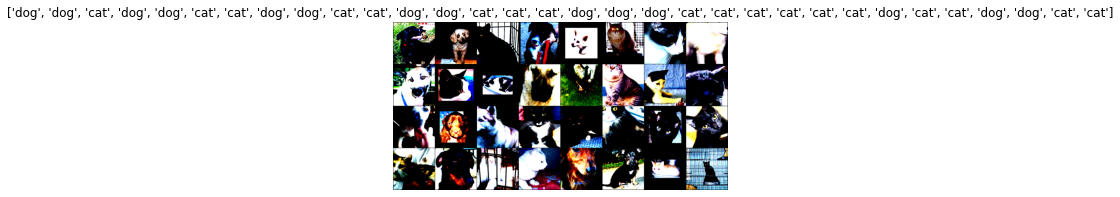

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [ ]:
Epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data_im in pbar:
        # get the inputs
        inputs, labels = data_im
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    # torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/18000 (0%)]	Loss: 0.693147: : 0it [00:01, ?it/s]
Train Epoch: 0 [0/18000 (0%)]	Loss: 0.693147: : 1it [00:01,  1.20s/it]
Train Epoch: 0 [32/18000 (0%)]	Loss: 0.693112: : 1it [00:02,  1.20s/it]
Train Epoch: 0 [32/18000 (0%)]	Loss: 0.693112: : 2it [00:02,  1.21s/it]
Train Epoch: 0 [64/18000 (0%)]	Loss: 0.693053: : 2it [00:03,  1.21s/it]
Train Epoch: 0 [64/18000 (0%)]	Loss: 0.693053: : 3it [00:03,  1.23s/it]
Train Epoch: 0 [96/18000 (1%)]	Loss: 0.692933: : 3it [00:04,  1.23s/it]
Train Epoch: 0 [96/18000 (1%)]	Loss: 0.692933: : 4it [00:04,  1.24s/it]
Train Epoch: 0 [128/18000 (1%)]	Loss: 0.692816: : 4it [00:06,  1.24s/it]
Train Epoch: 0 [128/18000 (1%)]	Loss: 0.692816: : 5it [00:06,  1.25s/it]
Train Epoch: 0 [160/18000 (1%)]	Loss: 0.692669: : 5it [00:07,  1.25s/it]
Train Epoch: 0 [160/18000 (1%)]	Loss: 0.692669: : 6it [00:07,  1.26s/it]
Train Epoch: 0 [192/18000 (1%)]	Loss: 0.692489: : 6it [00:08,  1.26s/it]
Train Epoch: 0 [192/18000 (1%)]	Loss: 0.69248

Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for datat in testloader:
        images, labels = datat
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [ ]:
print(total)
print(correct)

18000
8875
